In [1]:
from fastai.vision.all import *

In [2]:
base_path = Path('src')

img_train = base_path / 'train_images'
img_test = base_path / 'test_images'

In [3]:
df_train = pd.read_csv(base_path / 'train.csv')
df_test = pd.read_csv(base_path / 'test.csv')

In [4]:
df_train['image'] = df_train['image'].apply(lambda x: img_train / x)

## create smaller dataset

In [5]:
x = df_train['label_group'].unique()
y = np.random.choice(x, size = int(len(x)*0.1), replace = False)
df_train = df_train[df_train['label_group'].isin(y)]
df_train = df_train.reset_index(drop = True)

In [6]:
df_train.head()

,posting_id,image,image_phash,title,label_group
0,train_2720300071,src/train_images/005742b269e0ea4b352235b084e88eb4.jpg,f9ce8693394ccc91,Laneige Cica Sleeping Mask Sample 10ml Original Masker Wajah Leneige Masker Tidur Lanege,2653016647
1,train_4193869534,src/train_images/005bb468c673fb7f70319c120fb7106b.jpg,fee3811cf36224c3,Pelindung Lutut Bayi | Kaos Kaki Baby Knee Pad Protector,983229802
2,train_1243594898,src/train_images/006860e5c85173a4949a924ddcb5127a.jpg,a317b5e8d621cae1,TRACK RACER THOMAS SUPER MOTORDROME I,1990957212
3,train_149323111,src/train_images/009d89f1323ec58521af3fb2aaa4ea5e.jpg,ec85d23ee429c396,Bantal Olus Pillow Bayi - Bantal Anti Peyang untuk Terapi dan Kesehatan Bayi,151221854
4,train_472067494,src/train_images/00a866b5d5db175b782db8c01a8e178a.jpg,b490ea6b8bc784dc,BSB gantungan hp strap phone tali leher motif sport all type hp,981370797


In [7]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns):
        return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx = None, **kwargs):
        t1, t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape:
            return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        
        return show_image(torch.cat([t1,line,t2], dim=2), ctx = ctx, **kwargs)

In [8]:
files = L(df_train.image.tolist())

In [9]:
img = ImageTuple.create((files[0], files[1]))
tst = ToTensor()(img)
type(tst[0]),type(tst[1])

(fastai.torch_core.TensorImage, fastai.torch_core.TensorImage)

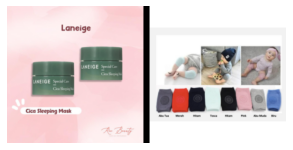

In [10]:
img1 = Resize(224)(img)
tst = ToTensor()(img1)
tst.show();

In [11]:
def ImageTupleBlock():
    return TransformBlock(type_tfms = ImageTuple.create, batch_tfms = IntToFloatTensor)

`splits` is a 2-tuple of L-lists. The first element is the list of indices of the training files, the second a list of the indices of the validation files. They are used to mask the files L-lists.

In [12]:
def split_by_label(df):
    # L-list of unique labels
    labels = L(df.label_group.unique().tolist())
    # Randomly split labels
    split_labels = RandomSplitter(valid_pct=0.2)(labels)  # Returns 80/20 split of labels

    # Mask labels to receive train/val labels
    train_labels = labels[split_labels[0]]
    validation_labels = labels[split_labels[1]]

    # Add colum to mark file as a part of the training/validation set
    df['is_valid'] = df_train.label_group.isin(validation_labels)

    # Sanity check:
    assert((df.groupby(['label_group'])['is_valid'].nunique() > 1).sum() == 0)
    
    files = L(df['image'].tolist())
    train_idx = df[df['is_valid'] == False].index.tolist()
    validation_idx = df[df['is_valid'] == True].index.tolist()
    
    # Sanity check:
    assert(set(files[train_idx]) == set(df[df['is_valid'] == False]['image']))
    assert(set(files[validation_idx]) == set (df[df['is_valid'] == True]['image']))
    
    return files, train_labels, validation_labels, train_idx, validation_idx

In [13]:
files, train_labels, validation_labels, train_split, val_split = split_by_label(df_train)
splits = (train_split, val_split)
labels = (train_labels,validation_labels)

In [14]:
# Splitting the labels 80/20 also results in a ~80/20 file-split
n = len(files)
print(len(splits[0])/n, len(splits[1])/n)

0.8008658008658008 0.19913419913419914


In [15]:
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

In [16]:
def get_split(f):
    for i,s in enumerate(splits_sets):
        if f in s:
            return i
    raise ValueError(f'File {f} is not presented in any split.')

In [17]:
def label_func(f):
    return df_train[df_train['image'] == f]['label_group'].values[0]

In [18]:
# Sanity check, all labels blong either to the training OR the validation set
assert(set(mapped(label_func,splits_files[0])).intersection(set(mapped(label_func, splits_files[1]))) == set())

In [19]:
# from fastai tutorial, not suitable for large number of labels! Make use of the dataframe.
# splbl2files = [{l: [f for f in s if label_func(f) == l] for l in labels} for s in splits_sets]
splbl2files = [(df_train.loc[splits[i]]).groupby(['label_group'])['image'].apply(list).to_dict() for i in range(2)]

In [20]:
def splitter(items):
    def get_split_files(i):
        return [j for j,(f1,f2,same) in enumerate(items) if get_split(f1) == i]
    return get_split_files(0), get_split_files(1)

-----------------

In [21]:
def draw_other(f):
    same = random.random() < 0.5
    cls = label_func(f)
    split = get_split(f)
    if not same:
        ## src
        # cls = random.choice(L(l for l in labels if 1 != cls))
        # make shure to pick a label that is from the same split
        cls = random.choice(L(l for l in labels[split] if l != cls))
    ## src
    #return random.choice(splbl2files[split][cls]),same
    # make shure to not pick the input file itself
    return random.choice([f2 for f2 in splbl2files[split][cls] if f2 != f]), same

In [22]:
def get_tuples(files):
    return [[f, *draw_other(f)] for f in files]

In [23]:
def get_x(t):
    return t[:2]
def get_y(t):
    return t[2]

In [24]:
siamese = DataBlock(
    blocks = (ImageTupleBlock, CategoryBlock),
    get_items = get_tuples,
    get_x = get_x,
    get_y = get_y,
    splitter = splitter,
    item_tfms = Resize(224),
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
)

In [25]:
dls = siamese.dataloaders(files, bs = 2)

In [26]:
b = dls.one_batch()

In [27]:
explode_types(b)

{tuple: [{__main__.ImageTuple: [fastai.torch_core.TensorImage,
    fastai.torch_core.TensorImage]},
  fastai.torch_core.TensorCategory]}

In [28]:
@typedispatch
def show_batch(x:ImageTuple, 
               y, 
               samples, 
               ctxs=None, 
               max_n=6, 
               nrows=None, 
               ncols=2, 
               figsize=None, 
               **kwargs):
    if figsize is None: 
        figsize = (ncols*6, max_n//ncols * 3)
        
    if ctxs is None: 
        ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
        
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    
    return ctxs

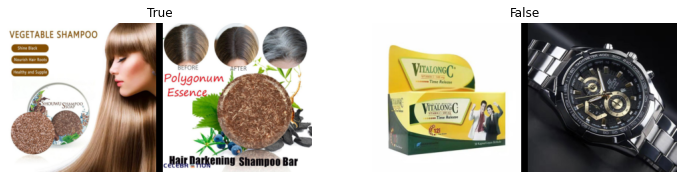

In [29]:
dls.show_batch()

***Note:*** Some instances that are not the same, can still have the same picture. See if this needs attention.

In [30]:
#twins = []
#for i in range(2):
#    for label in splbl2files[i].keys():
#        remaining = splbl2files[i][label]
#        touched = []
#        for f1 in remaining:
#            touched.append(f1)
#            remaining = [g for g in remaining if g not in touched]
#            img1 = np.array(Image.open(f1)
#                            .convert('L')
#                            .resize(((224,224)))
#                           ).astype(np.int)
#            
#            for f2 in remaining:
#                img2 = np.array(Image.open(f2)
#                            .convert('L')
#                            .resize(((224,224)))
#                           ).astype(np.int)            
#                diff = np.abs(img1 - img2).sum()
#                twins.append([f1,f2,diff])
#


In [31]:
#tuples = get_tuples(files)
#true_tuples = [x[:2] for x in tuples if x[2] == True]
# c=0
####
#f1,f2 =true_tuples[c]
#img1, img2 = Image.open(f1), Image.open(f2)
#
#plt.subplot(1,2,1)
#plt.imshow(img1)
#plt.subplot(1,2,2)
#plt.imshow(img2)
#
#c += 1

-----------------

In [32]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.head = head
        
    def forward(self, x):
        ftrs = torch.cat([self.encoder(x[0]), self.encoder(x[1])], dim = 1)
        return self.head(ftrs)

In [33]:
cut = model_meta[resnet34]['cut']

In [34]:
encoder = create_body(resnet34, cut = cut)

In [35]:
encoder[-1]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [36]:
head = create_head(512 * 2, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [37]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [38]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [39]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [47]:
learn = Learner(dls,model,loss_func=loss_func, splitter=siamese_splitter, metrics = accuracy)

In [48]:
learn.freeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=6.309573450380412e-07)

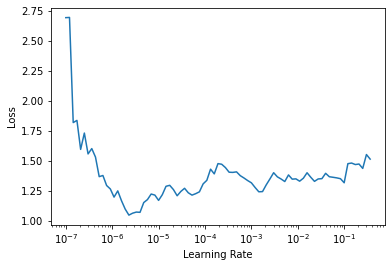

In [49]:
learn.lr_find()

In [50]:
learn.fit_one_cycle(10, 2e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.431209,0.989196,0.514493,01:12
1,1.161281,0.905510,0.508696,01:12
2,1.166807,0.917470,0.530435,01:13
3,0.937399,0.904697,0.491304,01:13
4,0.962153,0.878464,0.514493,01:13
5,0.903572,0.794309,0.531884,01:13
6,0.872642,0.784378,0.515942,01:13
7,0.849321,0.807682,0.504348,01:13
8,0.834894,0.779591,0.502899,01:14
9,0.838675,0.745986,0.514493,01:14


In [55]:
learn.unfreeze()

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=6.309573450380412e-07)

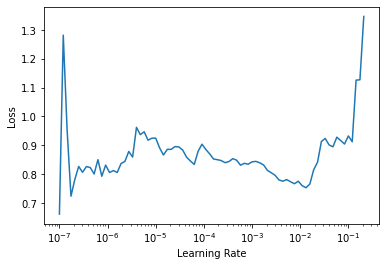

In [56]:
learn.lr_find()

In [57]:
learn.fit_one_cycle(25, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.815394,0.744960,0.521739,01:23
1,0.805150,0.741479,0.498551,01:22
2,0.807730,0.743957,0.478261,01:22
3,0.731809,0.732358,0.495652,01:24
4,0.840559,0.720511,0.504348,01:24
5,0.787018,0.745148,0.498551,01:24
6,0.753454,0.753509,0.489855,01:23
7,0.803314,0.706845,0.547826,01:25
8,0.746755,0.717681,0.524638,01:24
9,0.727662,0.697677,0.505797,01:24


In [58]:
learn.save('learner_resnet34_size224')

Path('models/learner_resnet34_size224.pth')

SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=0.2089296132326126)

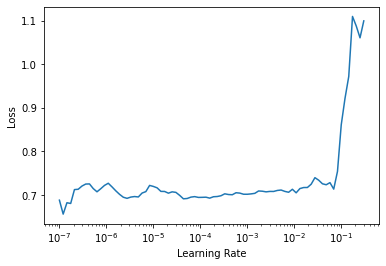

In [59]:
learn.lr_find()

In [63]:
learn.load('learner_resnet34_size224')

In [65]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.9054607491852948e-06)

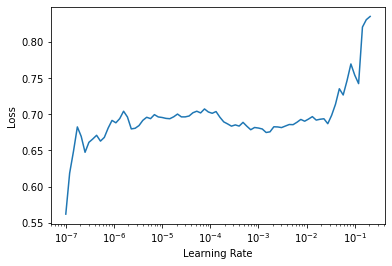

In [66]:
learn.lr_find()

In [67]:
learn.fit_one_cycle(50, slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.704933,0.702790,0.508696,01:25
1,0.730370,0.713741,0.530435,01:24
2,0.738173,0.787745,0.504348,01:22
3,0.726559,0.729728,0.485507,01:23
4,0.730777,0.748386,0.478261,01:23
5,0.697686,0.862472,0.505797,01:23
6,0.783143,0.699863,0.500000,01:23
7,0.845241,0.912738,0.540580,01:24
8,0.831230,2.399155,0.537681,01:23
9,0.848900,13.226825,0.456522,01:23


In [68]:
!dir

fastai_siamese_clone.ipynb  Shopee\ Explore.ipynb     Siamese\ NN.ipynb
models			    Siamese\ Datablock.ipynb  src


In [69]:
! git ../ add .

git: '../' ist kein Git-Befehl. Siehe 'git --help'.
